In [1]:
import torch

In [2]:
import os
import copy
import json
import threading
import logging

from transformers import HfArgumentParser, AutoTokenizer, PreTrainedTokenizerFast
from concurrent.futures import ThreadPoolExecutor
from typing import List, Dict
from datasets import Dataset, load_dataset

In [3]:
import sys
sys.path.append('smart-search/corag/src/')

In [5]:
from config import Arguments
from logger_config import logger
from data_utils import log_random_samples, load_corpus, format_documents_for_final_answer
from vllm_client_local import VllmClient, get_vllm_model_id
from utils import save_json_to_file, AtomicCounter
from agent import CoRagAgent, RagPath
from inference.metrics import compute_metrics_dict

In [4]:
vllm_ip = "10.197.17.39"
e5_ip = "10.197.17.38"

In [6]:
vllm_client: VllmClient = VllmClient(get_vllm_model_id(host=vllm_ip), host=vllm_ip)
corpus: Dataset = load_corpus()

[2025-04-18 13:58:21,753 INFO] HTTP Request: GET http://10.197.17.39:8000/v1/models "HTTP/1.1 200 OK"


Resolving data files:   0%|          | 0/37 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/37 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/37 [00:00<?, ?it/s]

[2025-04-18 13:58:24,555 INFO] Loaded 35678076 passages from corag/kilt-corpus


In [9]:
corag_agent: CoRagAgent = CoRagAgent(vllm_client=vllm_client, corpus=corpus, e5_ip=e5_ip, vllm_ip=vllm_ip)

[2025-04-07 22:49:30,482 INFO] HTTP Request: GET http://10.197.17.39:8000/v1/models "HTTP/1.1 200 OK"


In [69]:
import heapq
import math
from copy import deepcopy
from typing import Optional, List, Dict

from agent.agent_utils import RagPath
from openai.types.chat import ChatCompletion
from prompts import get_generate_subquery_prompt, get_generate_intermediate_answer_prompt, get_generate_final_answer_prompt

from agent.corag_agent import CoRagAgent
from agent.corag_agent import _normalize_subquery

from vllm_client_local import VllmClient
from datasets import Dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [88]:
class TreeNode:
    def __init__(self, path: RagPath, logprob: float, parent: Optional["TreeNode"] = None):
        self.path = deepcopy(path)
        self.logprob = logprob  # cumulative log probability of subqueries
        self.depth = len(path.past_subqueries)
        self.parent = parent
        self.children = []
        self.levin_cost = 0.0

    def __lt__(self, other):
        return self.levin_cost < other.levin_cost
    
class CoRagAgentWithPHS(CoRagAgent):
    
    def __init__(self, vllm_client: VllmClient, corpus: Dataset, e5_ip: str, vllm_ip: str, 
                 confidence_threshold: float = 0.5):
        """Initializes the CoRagAgentWithPHS class.
        This class is a specialized version of the CoRagAgent that implements a tree search algorithm
        called 'Policy-guided heuristic search' (PHS) to quickly find a good path for answering a query.

        Args:
            vllm_client (VllmClient): VLLM client for answering queries.
            corpus (Dataset): Dataset containing the documents to be searched.
            e5_ip (str): IP address of the E5 server.
            vllm_ip (str): IP address of the VLLM server.
            confidence_threshold (float, optional): Confidence threshold to determine if completed. Defaults to 0.5.
        """
        super().__init__(vllm_client, corpus, e5_ip, vllm_ip)
        self.confidence_threshold = confidence_threshold
        self.embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.similarity_threshold = 0.95
        
    def filter_similar_subqueries(self, choices):
        filtered_indices = []
        subqueries = [_normalize_subquery(choice.message.content) for choice in choices]
        embeddings = self.embedding_model.encode(subqueries, show_progress_bar=False)
        
        # cluster the embeddings by cosine similarity of the embeddings
        for i in range(len(embeddings)):
            is_similar = False
            for j in range(i):
                sim = cosine_similarity(
                    embeddings[i].reshape(1,-1), 
                    embeddings[j].reshape(1,-1)
                    # dim=0
                ).item()
                if sim > self.similarity_threshold:
                    is_similar = True
                    break
            if not is_similar:
                filtered_indices.append(i)
        return [choices[i] for i in filtered_indices]

    def tree_search(
        self, query: str, 
        task_desc: str,
        max_path_length: int = 3,
        max_message_length: int = 4096,
        temperature: float = 0.7,
        expand_size: int = 4,
        max_tree_size = 100,
        **kwargs
    ) -> RagPath:
        root_path = RagPath(query=query, past_subqueries=[query], past_subanswers=[], past_doc_ids=[])
        root_node = TreeNode(path=root_path, logprob=0.0)
        all_nodes = []
        open_list = []
        heapq.heappush(open_list, root_node)
        explored_num = 0
        while open_list and explored_num < max_tree_size:
            print(f"Explored nodes: {explored_num}, Open list size: {len(open_list)}")
            explored_num += 1
            node = heapq.heappop(open_list)
            current_path = node.path
            
            subquery = node.path.past_subqueries[-1]
            subanswer, doc_ids = self._get_subanswer_and_doc_ids(
                subquery=subquery, max_message_length=max_message_length
            )
            
            current_path.past_subanswers.append(subanswer)
            current_path.past_doc_ids.append(doc_ids)
            # now the subanswers and subqueries are the same length
            
            # if self._is_solution(current_path, task_desc, max_message_length):
            #     return current_path

            messages = get_generate_subquery_prompt(
                query=query,
                past_subqueries=current_path.past_subqueries,
                past_subanswers=current_path.past_subanswers,
                task_desc=task_desc
            )
            self._truncate_long_messages(messages, max_length=max_message_length)

            completion: ChatCompletion = self.vllm_client.call_chat(
                messages=messages,
                return_str=False,
                n=expand_size,
                # extra_body={"prompt_logprobs": 1},
                logprobs=True,
                temperature=temperature,
                **kwargs
            )
            
            filtered_choices = self.filter_similar_subqueries(completion.choices)

            for choice in filtered_choices:
                subquery = _normalize_subquery(choice.message.content)
                if subquery in current_path.past_subqueries:
                    continue
                
                token_logprobs = [c.logprob for c in choice.logprobs.content]
                
                sub_logprob = sum(token_logprobs) / max(len(token_logprobs), 1)
                
                new_path = RagPath(
                    query=query,
                    past_subqueries=current_path.past_subqueries + [subquery],
                    past_subanswers=current_path.past_subanswers,
                    past_doc_ids=current_path.past_doc_ids
                )

                running_cost = len(new_path.past_subqueries) # number of nodes (g(n) in the paper)
                policy_logprob = node.logprob + sub_logprob # cumulative log probability (log(pi(n)) in the paper)
                # heuristic_cost = self._estimate_heuristic_llm(new_path, task_desc, max_message_length, **kwargs) # h(n) in the paper
                heuristic_cost = max_path_length - len(new_path.past_subqueries) # h(n) in the paper
                levin_cost = math.log(running_cost + heuristic_cost + 1e-5) - policy_logprob

                new_node = TreeNode(path=new_path, logprob=policy_logprob, parent=node)
                node.children.append(new_node)
                all_nodes.append(new_node)
                new_node.levin_cost = levin_cost
                heapq.heappush(open_list, new_node)
                
        # Loop over all leaf nodes and choose the best one according to _eval_single_path
        best_node = None
        best_score = float('inf')
        for node in all_nodes:
            if len(node.children) > 0:
                continue
            path = node.path
            
            if len(path.past_subqueries) > len(path.past_subanswers):
                # If the path is not complete, complete it
                subanswer, doc_ids = self._get_subanswer_and_doc_ids(
                    subquery=path.past_subqueries[-1], max_message_length=max_message_length
                )
                
                path.past_subanswers.append(subanswer)
                path.past_doc_ids.append(doc_ids)
            
            score = self._eval_single_path(path, max_message_length=max_message_length)
            if score < best_score:
                best_score = score
                best_node = node
        if best_node is not None:
            return best_node.path, root_node
        # If no solution was found, return the root path
        # This is a fallback and should not happen in normal circumstances.
        # logger.warning(f"Did not find a solution within {max_tree_size} nodes. Returning the root path.")
        # This should never happen, but just in case
        return self.root_path

    def _is_solution(self, path: RagPath, task_desc: str, max_message_length: int) -> bool:
        log_prob = self._eval_single_path(
            path,
            max_message_length=max_message_length
        )
        # This is the log probability of the string 'No relevant information found'
        # So, if the log probability of the path is less than this, we consider it a solution.
        # This is a heuristic, and the threshold can be adjusted based on the model's behavior.
        return log_prob < math.log(self.confidence_threshold)

    def _estimate_heuristic_llm(self, path: RagPath, task_desc: str, max_message_length: int, **kwargs) -> int:
        """Heuristic function to estimate the number of remaining subqueries.
        This function uses the LLM to predict how many subqueries are needed to fully answer the original query.

        Args:
            path (RagPath): RagPath to the current node in the search tree
            task_desc (str): Task description
            max_message_length (int): Maximum message length for the LLM
            **kwargs: Additional arguments for the LLM call

        Returns:
            int: Estimated number of remaining subqueries
        """
        # Ask the LLM how many subqueries it expects are remaining
        messages: List[Dict] = get_generate_intermediate_answer_prompt(
            subquery=path.query,
            documents=[f'Q: {q}\nA: {a}' for q, a in zip(path.past_subqueries, path.past_subanswers)],
        )
        # messages.append({'role': 'user', 'content': 'How many more subqueries are needed to fully answer the original query. Respond with a single integer.'})
        messages.append({'role': 'user', 
                         'content': f'What additional subqueries should be asked to fully answer the original query: "{path.query}". Separate subqueries with question marks "?".'})
        self._truncate_long_messages(messages, max_length=max_message_length)

        response: ChatCompletion = self.vllm_client.call_chat(
            messages=messages,
            return_str=False,
            # max_tokens=5,
            **kwargs
        )

        text = response.choices[0].message.content.strip()
        
        est_remaining = max(1,len(text.split("?")))

        # response: ChatCompletion = self.vllm_client.call_chat(
        #     messages=messages,
        #     return_str=False,
        #     max_tokens=5,
        #     **kwargs
        # )

        # # idk how to ensure its an int, this was an attempt
        # try:
        #     est_remaining = int(text.split()[0])
        # except Exception:
        #     est_remaining = max(1, 3 - len(path.past_subqueries))  # fallback

        return max(0, est_remaining)

In [9]:
tokenizer: PreTrainedTokenizerFast = AutoTokenizer.from_pretrained(get_vllm_model_id(host=vllm_ip))
tokenizer_lock: threading.Lock = threading.Lock()
processed_cnt: AtomicCounter = AtomicCounter()
total_cnt: int = 0

[2025-04-18 13:58:38,822 INFO] HTTP Request: GET http://10.197.17.39:8000/v1/models "HTTP/1.1 200 OK"


In [10]:
ds: Dataset = load_dataset('corag/multihopqa', "hotpotqa", split="validation")
ds = ds.remove_columns([name for name in ['subqueries', 'subanswers', 'predictions'] if name in ds.column_names])
ds = ds.add_column('task_desc', ['answer multi-hop questions' for _ in range(len(ds))])

In [11]:
ds = ds.select(range(16))
args = Arguments()
ex = ds[0]

In [81]:
cosine_similarity(
    [[1, 2, 3]],
    [[1, 2, 3]]
).item()

1.0

In [87]:
def filter_similar_subqueries(subqueries):
    filtered_indices = []
    # subqueries = [_normalize_subquery(choice.message.content) for choice in choices]
    embeddings = embedding_model.encode(subqueries, show_progress_bar=False)
    # cluster the embeddings by cosine similarity of the embeddings
    for i in range(len(embeddings)):
        is_similar = False
        for j in range(i):
            sim = cosine_similarity(
                embeddings[i].reshape(1,-1), 
                embeddings[j].reshape(1,-1)
                # dim=0
            ).item()
            if sim > 0.95:
                is_similar = True
                break
        if not is_similar:
            filtered_indices.append(i)
    return [subqueries[i] for i in filtered_indices]

filter_similar_subqueries(subqueries)

["What was Ed Wood's birthplace?",
 'Was Ed Wood born in the United States?',
 'Was Ed Wood American?']

In [89]:
phs_agent = CoRagAgentWithPHS(
    vllm_client=vllm_client,
    corpus=corpus,
    e5_ip=e5_ip,
    vllm_ip=vllm_ip,
    confidence_threshold=0.05
)

path = phs_agent.tree_search(
        query=ex['query'], 
        task_desc=ex['task_desc'],
        max_path_length=3,
        expand_size=4,
        temperature=0.7,
        max_tree_size=10
    )

[2025-04-18 14:49:08,856 INFO] HTTP Request: GET http://10.197.17.39:8000/v1/models "HTTP/1.1 200 OK"


[2025-04-18 14:49:09,500 INFO] Use pytorch device_name: cpu
[2025-04-18 14:49:09,501 INFO] Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Explored nodes: 0, Open list size: 1


[2025-04-18 14:49:10,682 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:10,878 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 1, Open list size: 2


[2025-04-18 14:49:11,152 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:11,320 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:11,521 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 2, Open list size: 2


[2025-04-18 14:49:11,688 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:11,897 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 3, Open list size: 2


[2025-04-18 14:49:12,062 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 4, Open list size: 4


[2025-04-18 14:49:12,445 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:12,659 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 5, Open list size: 4


[2025-04-18 14:49:12,907 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:13,077 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 6, Open list size: 3


[2025-04-18 14:49:13,326 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:13,543 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:13,734 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 7, Open list size: 4


[2025-04-18 14:49:13,931 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 8, Open list size: 6


[2025-04-18 14:49:14,206 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:14,421 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


Explored nodes: 9, Open list size: 7


[2025-04-18 14:49:14,703 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:14,949 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:15,138 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:15,175 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:15,213 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:15,389 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:15,426 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:15,601 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-18 14:49:15,638 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "

In [ ]:
path: RagPath = corag_agent.sample_path(
        query=ex['query'], 
        task_desc=ex['task_desc'],
        max_path_length=6,
        temperature=0., 
        max_tokens=64
    )

[2025-04-07 17:27:01,817 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-07 17:27:02,093 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-07 17:27:02,251 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-07 17:27:02,394 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-07 17:27:02,719 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-07 17:27:02,864 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-07 17:27:03,019 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-07 17:27:03,175 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "HTTP/1.1 200 OK"
[2025-04-07 17:27:03,317 INFO] HTTP Request: POST http://10.197.17.38:8000/v1/chat/completions "

In [90]:
best_path, root_node = path

In [91]:
root_node.path.query

'Were Scott Derrickson and Ed Wood of the same nationality?'

In [92]:
subqueries = [c.path.past_subqueries[-1] for c in root_node.children]
subqueries

['Was Ed Wood born in the United States?',
 'What was the nationality of Ed Wood?']

In [93]:
documents: List[str] = format_documents_for_final_answer(
    args=args,
    context_doc_ids=ex['context_doc_ids'],
    tokenizer=tokenizer, corpus=corpus,
    lock=tokenizer_lock
)

In [94]:
prediction: str = phs_agent.generate_final_answer(
        corag_sample=best_path,
        task_desc=ex['task_desc'],
        documents=documents,
        max_message_length=args.max_len,
        temperature=0., max_tokens=128
    )

ex_with_path = copy.deepcopy(ex)
ex_with_path['subqueries'] = best_path.past_subqueries
ex_with_path['subanswers'] = best_path.past_subanswers
ex_with_path['path_doc_ids'] = best_path.past_doc_ids
if 'title' in corpus.column_names:
    ex_with_path['path_doc_titles'] = [
        [corpus[int(doc_id)]['title'] for doc_id in doc_ids] for doc_ids in best_path.past_doc_ids
    ]
ex_with_path['prediction'] = prediction

[2025-04-18 14:49:27,937 INFO] HTTP Request: POST http://10.197.17.39:8000/v1/chat/completions "HTTP/1.1 200 OK"


In [95]:
ex_with_path['subqueries']

['Were Scott Derrickson and Ed Wood of the same nationality?',
 'What was the nationality of Ed Wood?',
 'What was the nationality of Scott Derrickson?',
 'Is Ed Wood American?',
 'Is Ed Wood the same nationality as Scott Derrickson?']

In [96]:
ex_with_path['subanswers']

['Yes', 'American', 'American.', 'Yes', 'Yes']

# Metrics

In [3]:
from inference.metrics import compute_metrics_dict
from inference.qa_utils import *
import json
from typing import List, Dict

In [4]:
def read_jsonl(file_path: str) -> List[Dict]:
    """
    Reads a JSONL (JSON Lines) file and returns a list of dictionaries.

    Args:
        file_path (str): Path to the JSONL file.

    Returns:
        List[Dict]: List of dictionaries representing the JSON objects in the file.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        return [json.loads(line) for line in file]

In [64]:
preds_phs_list = read_jsonl('tmp/6/preds_phs_hotpotqa_validation.jsonl')
preds_tree_search_list = read_jsonl('tmp/6/preds_tree_search_hotpotqa_validation.jsonl')
preds_greedy_list = read_jsonl('tmp/6/preds_greedy_hotpotqa_validation.jsonl')[:1000]
preds_phs_8_list = read_jsonl('tmp/8/preds_phs_hotpotqa_validation.jsonl')

In [65]:
preds_phs = [d['prediction'] for d in preds_phs_list]
preds_phs_8 = [d['prediction'] for d in preds_phs_8_list]
answers = [d['answers'] for d in preds_phs_list]
preds_tree_search = [d['prediction'] for d in preds_tree_search_list]
preds_greedy = [d['prediction'] for d in preds_greedy_list]

In [67]:
labels = [[normalize_squad(t) for t in u] for u in answers]
preds_phs = [normalize_squad(p) for p in preds_phs]
preds_phs_8 = [normalize_squad(p) for p in preds_phs_8]
preds_tree_search = [normalize_squad(p) for p in preds_tree_search]
preds_greedy = [normalize_squad(p) for p in preds_greedy]

# Compute metrics
em_phs, f1_phs, em_scores_phs, f1_scores_phs = qa_metrics(labels, preds_phs)  # em,f1
em_phs_8, f1_phs_8, em_scores_phs_8, f1_scores_phs_8 = qa_metrics(labels, preds_phs_8)  # em,f1
em_tree_search, f1_tree_search, em_scores_tree_search, f1_scores_tree_search = qa_metrics(labels, preds_tree_search)  # em,f1
em_greedy, f1_greedy, em_scores_greedy, f1_scores_greedy = qa_metrics(labels, preds_greedy)  # em,f1

In [68]:
em_phs, em_phs_8, em_tree_search, em_greedy

(52.0, 52.400000000000006, 51.6, 51.800000000000004)

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[2025-04-10 11:18:16,694 INFO] generated new fontManager


Text(0.5, 0, 'CoRAG Tree Search')

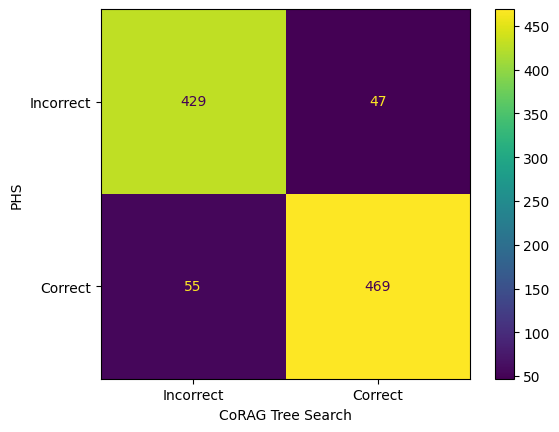

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix(
    [1 if em else 0 for em in em_scores_phs_8],
    [1 if em else 0 for em in em_scores_tree_search]
), display_labels=['Incorrect', 'Correct'])
disp.plot()
plt.ylabel('PHS')
plt.xlabel('CoRAG Tree Search')

Text(0.5, 0, 'CoRAG Greedy')

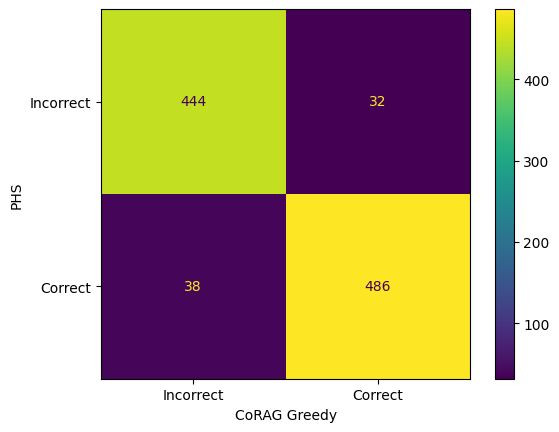

In [70]:
disp = ConfusionMatrixDisplay(confusion_matrix(
    [1 if em else 0 for em in em_scores_phs_8],
    [1 if em else 0 for em in em_scores_greedy]
), display_labels=['Incorrect', 'Correct'])
disp.plot()
plt.ylabel('PHS')
plt.xlabel('CoRAG Greedy')

Text(0.5, 0, 'PHS (Max Depth 6)')

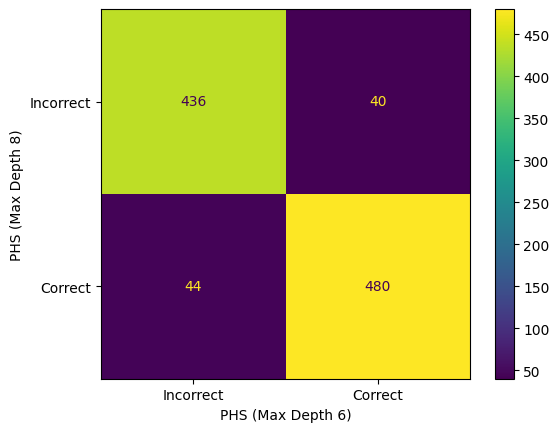

In [72]:
disp = ConfusionMatrixDisplay(confusion_matrix(
    [1 if em else 0 for em in em_scores_phs_8],
    [1 if em else 0 for em in em_scores_phs]
), display_labels=['Incorrect', 'Correct'])
disp.plot()
plt.ylabel('PHS (Max Depth 8)')
plt.xlabel('PHS (Max Depth 6)')

The reason for this is that when PHS does not find a solution that it is confident in, it just samples a path greedily. We should change the logic to instead use the best path of the ones that is has found.

We can couple this with the test of removing `is_solution` entirely and instead just exploring a tree of preset size and choosing the best leaf node.